In [2]:
from edgedroid import data as e_data

data, *_ = e_data.load_default_exec_time_data()
data

,run_id,ttf,exec_time,neuroticism
0,134146,0.597441,3.654797,0.375
1,134146,0.553513,4.438645,0.375
2,134146,0.561716,2.943222,0.375
3,134146,0.586512,5.405761,0.375
4,134146,0.558940,5.225161,0.375
...,...,...,...,...
6755,137353,0.557074,6.439071,0.625
6756,137353,0.534339,4.680858,0.625
6757,137353,0.560288,3.467878,0.625
6758,137353,0.579000,2.325759,0.625


In [3]:
ttfs = data["ttf"]
ttfs

0       0.597441
1       0.553513
2       0.561716
3       0.586512
4       0.558940
          ...   
6755    0.557074
6756    0.534339
6757    0.560288
6758    0.579000
6759    0.536671
Name: ttf, Length: 6760, dtype: float64

In [4]:
import pandas as pd
import numpy as np

_, bins = pd.qcut(ttfs, 3, retbins=True)
test_ttfs = ((bins + np.roll(bins, -1)) / 2)[:3]
test_ttfs

array([0.99397993, 2.3400237 , 4.60159577])

In [5]:
from edgedroid.models import *
from collections import deque
import itertools as it
from tqdm.notebook import tqdm

warmup_steps = 25
test_steps = 15
reps = 300
rng = np.random.default_rng()

def test_model_constant_ttf(model_name: str, model: ExecutionTimeModel, ttf: float) -> pd.DataFrame:
    rows = deque()
    for rep in range(reps):
        # warmup model
        model.reset()
        for _ in range(warmup_steps):
            model.advance(rng.choice(ttfs))

        for i in range(test_steps):
            exec_time = model.advance(ttf).get_execution_time()
            rows.append({
                "model": model_name,
                "ttf": ttf,
                "repetition": rep,
                "step": i,
                "exec_time": exec_time,
            })

    return pd.DataFrame(rows)


models = {
    "empirical-low": EmpiricalExecutionTimeModel(neuroticism=0.0),
    "empirical-high": EmpiricalExecutionTimeModel(neuroticism=1.0),
    "theoretical-low": TheoreticalExecutionTimeModel(neuroticism=0.0),
    "theoretical-high": TheoreticalExecutionTimeModel(neuroticism=1.0),
    "rolling-ttf-low": ExpKernelRollingTTFETModel(neuroticism=0.0),
    "rolling-ttf-high": ExpKernelRollingTTFETModel(neuroticism=1.0),
    "fitted-rolling-ttf-low": DistExpKernelRollingTTFETModel(neuroticism=0.0),
    "fitted-rolling-ttf-high": DistExpKernelRollingTTFETModel(neuroticism=1.0)
}

dfs = deque()
combs = list(it.product(models.items(), test_ttfs))
for (name, model), ttf in tqdm(combs, desc="Running models..."):
    dfs.append(test_model_constant_ttf(name, model, ttf))

results = pd.concat(dfs, ignore_index=True)
results

      rolling_ttf       ttf
0        0.597441  0.597441
1        0.575322  0.553513
2        0.568468  0.561716
3        0.577551  0.586512
4        0.568178  0.558940
...           ...       ...
6585     1.358618  0.546556
6586     0.957313  0.561450
6587     0.743101  0.531800
6588     0.641867  0.542005
6589     0.595819  0.550422

[3379 rows x 2 columns]
      rolling_ttf       ttf
169      0.561192  0.561192
170      0.566481  0.571696
171      1.594321  2.607756
172      2.399369  3.192904
173      2.528148  2.654708
...           ...       ...
6754     0.617497  0.577341
6755     0.586859  0.557074
6756     0.560164  0.534339
6757     0.559809  0.560288
6758     0.568989  0.579000

[3379 rows x 2 columns]
      rolling_ttf       ttf
0        0.597441  0.597441
1        0.575245  0.553513
2        0.568367  0.561716
3        0.577481  0.586512
4        0.568076  0.558940
...           ...       ...
6585     1.361230  0.546556
6586     0.958589  0.561450
6587     0.743730  0.53180

Running models...:   0%|          | 0/24 [00:00<?, ?it/s]

,model,ttf,repetition,step,exec_time
0,empirical-low,0.993980,0,0,3.448774
1,empirical-low,0.993980,0,1,7.798761
2,empirical-low,0.993980,0,2,4.752692
3,empirical-low,0.993980,0,3,6.336991
4,empirical-low,0.993980,0,4,3.832707
...,...,...,...,...,...
107995,fitted-rolling-ttf-high,4.601596,299,10,6.022189
107996,fitted-rolling-ttf-high,4.601596,299,11,7.654305
107997,fitted-rolling-ttf-high,4.601596,299,12,4.780683
107998,fitted-rolling-ttf-high,4.601596,299,13,5.415966


In [5]:
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style("whitegrid")
sns.set_context("paper", font_scale=1.5)
sns.set_palette("Dark2")

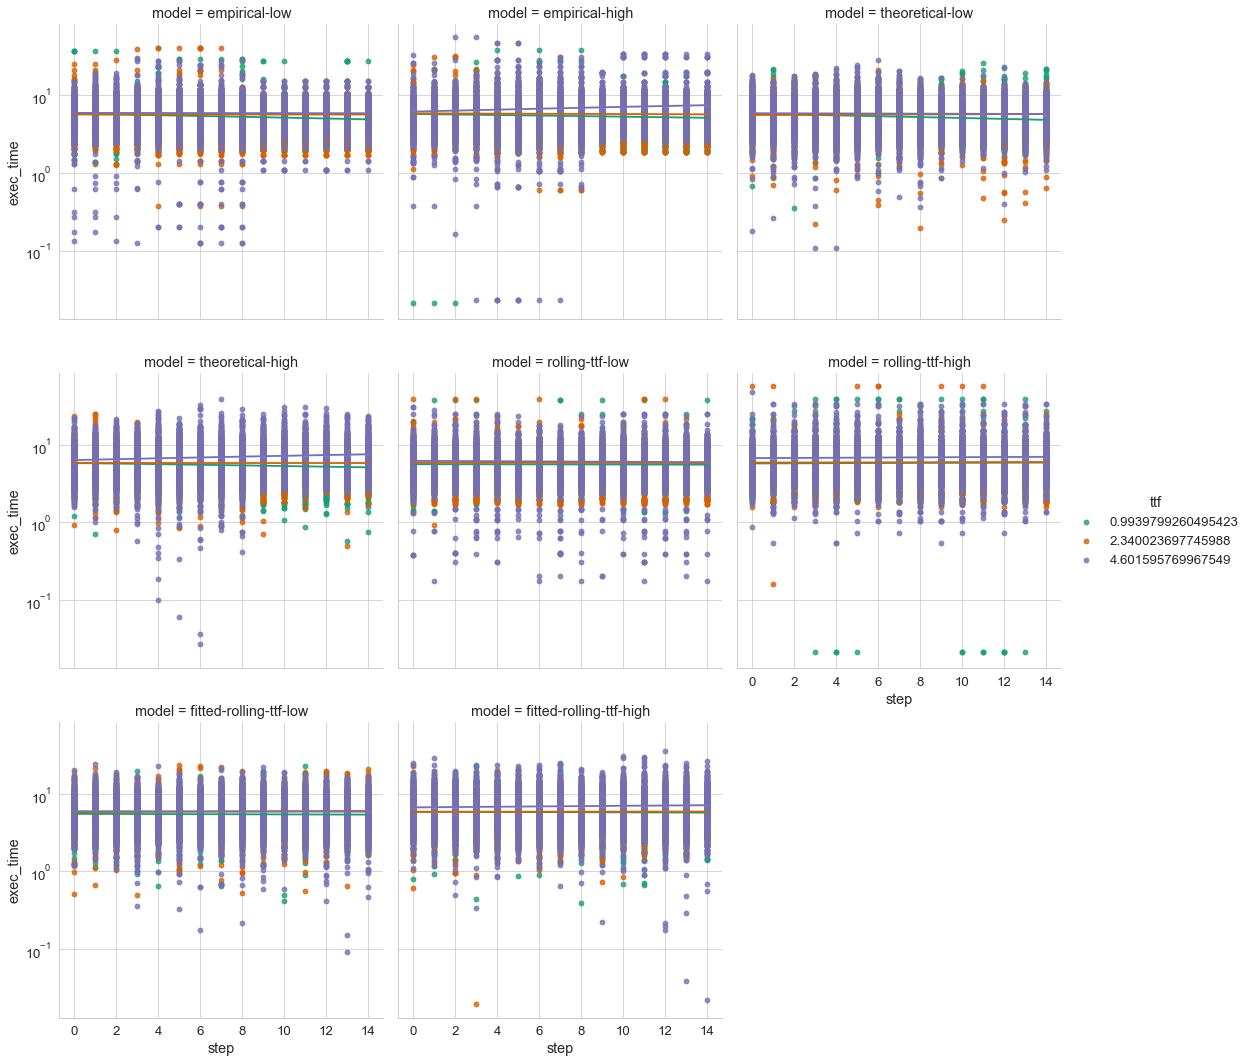

In [6]:
fg = sns.lmplot(
    data=results,
    x="step",
    y="exec_time",
    hue="ttf",
    col="model",
    col_wrap=3,
    fit_reg=True,
    # aspect=3,
)
fg.set(yscale="log")
plt.show()

In [7]:
rolling_results = results[results["model"].str.contains("rolling-ttf")]
(
    rolling_results
    .groupby(["model", "ttf", "step"])
    ["exec_time"]
    .describe()
    .loc[pd.IndexSlice[:, :, [0, 14]]]
)

count      mean       std       min  \
model                   ttf      step                                        
fitted-rolling-ttf-high 0.993980 0     300.0  6.046446  2.943849  0.794615   
                                 14    300.0  5.788393  2.739670  0.000000   
                        2.340024 0     300.0  6.105630  2.825503  0.602858   
                                 14    300.0  6.057135  2.263372  1.732132   
                        4.601596 0     300.0  6.367603  3.361496  1.115203   
                                 14    300.0  7.260260  3.987023  0.021874   
fitted-rolling-ttf-low  0.993980 0     300.0  5.789841  2.544176  0.000000   
                                 14    300.0  5.308048  2.264192  1.630379   
                        2.340024 0     300.0  5.646003  2.604138  0.503800   
                                 14    300.0  6.008491  2.908493  1.009408   
                        4.601596 0     300.0  6.065060  2.845489  1.191911   
                                 14    300.0  5.765159  2.692102  0.462066   
rolling-ttf-high        0.993980 0     300.0  5.605067  2.664680  1.841317   
                                 14    300.0  5.917321  2.961861  1.802406   
                        2.340024 0     300.0  5.920645  3.600998  1.590351   
                                 14    300.0  5.911561  2.750223  1.590351   
                        4.601596 0     300.0  6.322556  3.859946  0.876377   
                                 14    300.0  6.710713  3.936009  0.000355   
rolling-ttf-low         0.993980 0     300.0  5.686381  2.681229  1.396396   
                                 14    300.0  5.585237  2.953640  1.912741   
                        2.340024 0     300.0  5.922243  3.354482  1.303871   
                                 14    300.0  5.634575  2.326301  1.709817   
                        4.601596 0     300.0  5.955657  3.443029  0.374694   
                                 14    300.0  5.970952  2.901029  0.175089   

                                            25%       50%       75%        max  
model                   ttf      step                                           
fitted-rolling-ttf-high 0.993980 0     3.897883  5.425520  7.345341  17.430431  
                                 14    3.966234  5.113345  7.106371  18.466219  
                        2.340024 0     4.223561  5.699446  7.493655  22.916089  
                                 14    4.652609  5.669842  7.228764  15.403856  
                        4.601596 0     4.099568  5.678334  7.698556  24.849739  
                                 14    4.395684  6.274144  9.498081  26.074686  
fitted-rolling-ttf-low  0.993980 0     4.082215  5.271951  7.120955  17.152331  
                                 14    3.677818  4.771354  6.463607  14.942985  
                        2.340024 0     3.852143  5.171430  6.823176  19.231299  
                                 14    4.186767  5.286361  6.971042  20.791480  
                        4.601596 0     4.185085  5.433058  7.338063  20.330899  
                                 14    3.994032  5.311198  7.118741  17.069173  
rolling-ttf-high        0.993980 0     3.813033  5.231657  6.790009  21.727171  
                                 14    4.147058  5.458453  6.885305  27.247761  
                        2.340024 0     4.252554  5.550081  7.019580  56.162839  
                                 14    4.148138  5.607991  7.074699  25.152514  
                        4.601596 0     4.234142  5.633714  7.344106  47.027108  
                                 14    4.159413  6.055294  8.327300  33.812717  
rolling-ttf-low         0.993980 0     3.832308  5.174516  6.977937  19.565120  
                                 14    3.877691  4.992536  6.606019  37.976307  
                        2.340024 0     3.921590  5.183866  6.961644  39.141714  
                                 14    4.117207  5.183392  7.025765  13.628381  
                        4.601596 0     4.009397  5.186093  7.05715